<a href="https://colab.research.google.com/github/lmarieta/FaceRecognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, upload data.h5, data_submission.h5, IdLookupTable.csv and model.h5 files. After training your model, you can download it. After saving the output file, you can also download it.

Import Libraries


In [450]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import layers
import pandas as pd
import h5py
#from sklearn import train_test_split
import matplotlib.pyplot as plt
!pip install pyreadr
import pyreadr
from keras.optimizers import Adam
from timeit import default_timer
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, BatchNormalization
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from collections import OrderedDict
from tensorflow.keras.models import clone_model, load_model
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

Initialization

In [451]:
epochs = 1000
pretraining = False
batch_size = 32
seed = 42

Load data

In [452]:
data_filename = '/content/data.h5'
submission_filename = '/content/data_submission.h5'

## Get the indices of rows containing NaN values. Note that train and test splits are random with a given seed.
# nan_indices_train = x_train.index[x_train.isnull().any(axis=1)].tolist() + y_train.index[y_train.isnull().any(axis=1)].tolist()
# nan_indices_test = x_test.index[x_test.isnull().any(axis=1)].tolist() + y_test.index[y_test.isnull().any(axis=1)].tolist()

## Drop rows containing NaN values
# x_train = x_train.drop(x_train.index[nan_indices_train])
# y_train = y_train.drop(y_train.index[nan_indices_train])
# x_test = x_test.drop(x_test.index[nan_indices_test])
# y_test = y_test.drop(y_test.index[nan_indices_test])



In [453]:
def load(test=False, cols=None, fname=data_filename):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """

    with h5py.File(fname, 'r') as hdf_file:
      if (fname == data_filename and test == False):
        # Read DataFrames
        X = pd.DataFrame(hdf_file['im_train'][:])
        y = pd.DataFrame(hdf_file['d_train'][:])
        y.columns = hdf_file['d_train'].attrs['column_names']
      elif (fname == data_filename and test == True):
        # Read DataFrames
        X = pd.DataFrame(hdf_file['im_test'][:])
        y = pd.DataFrame(hdf_file['d_test'][:])
        y.columns = hdf_file['d_test'].attrs['column_names']
      else:
        # Read NumPy arrays
        X = pd.DataFrame(np.array(hdf_file['submission_image'][:]))

    if (cols and fname == data_filename):  # get a subset of columns
        y = y[list(cols)]

    X = np.vstack(X.values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if fname == data_filename:  # only FTRAIN has any target columns
        y = y.values
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [454]:
def load2d(test=False, cols=None, fname=data_filename):
    X, y = load(test=test,cols=cols,fname=fname)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [455]:
if pretraining == True:
  x_train, y_train = load2d(test = False, fname = data_filename)
else:
  x_train, y_train = load(test = False, fname = data_filename)
x_test, y_test = load2d(test = True, fname = data_filename)

# Find rows with NaN values
nan_rows = np.isnan(y_test).any(axis=1)

# Use boolean indexing to drop rows with NaN values
x_test = x_test[~nan_rows]
y_test = y_test[~nan_rows]

Model selection

In [456]:
model_type = 'Convolutions' # options: {'Single hidden layer','Convolutions'}
df = pd.DataFrame({model_type}, columns=['Model type'])

# Start recording time
start = default_timer()

Dynamic momentum and learning rate

In [457]:
class MomentumScheduler(Callback):
    def __init__(self, schedule, decay_rate):
        super(MomentumScheduler, self).__init__()
        self.initial_schedule = schedule
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'beta_1'):
            raise ValueError("Optimizer must have a 'beta_1' attribute.")
        momentum = self.initial_schedule + (self.decay_rate*epoch) / epochs
        self.model.optimizer.beta_1 = momentum


class LinearDecayLR(Callback):
    def __init__(self, initial_lr, decay_rate):
        super(LinearDecayLR, self).__init__()
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.initial_lr - (self.decay_rate * epoch) / epochs
        self.model.optimizer.lr = new_lr

# Initialize for learning rate and momentum
initial_momentum = 0.9 # TODO optimize
momentum_decay_rate = 0.999 - initial_momentum

initial_lr = 0.0005 # TODO optimize
final_lr = 0.00001
lr_decay_rate = initial_lr - final_lr

# Create callbacks
momentum_callback = MomentumScheduler(initial_momentum, momentum_decay_rate)
lr_callback = LinearDecayLR(initial_lr, lr_decay_rate)


Random picture shifting

In [458]:
class DataModifier(object):
    def fit(self,X_,y_):
        return(NotImplementedError)

class FlipPic(DataModifier):
    def __init__(self,flip_indices=None):
        if flip_indices is None:
            flip_indices = [
                (0, 2), (1, 3),
                (4, 8), (5, 9), (6, 10), (7, 11),
                (12, 16), (13, 17), (14, 18), (15, 19),
                (22, 24), (23, 25)
                ]

        self.flip_indices = flip_indices

    def fit(self,X_batch,y_batch):
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, int(batch_size/2), replace=False)

        X_batch[indices] = X_batch[indices, :, ::-1,:]
        y_batch[indices, ::2] = X_batch.shape[1] + y_batch[indices, ::2] * -1

        # flip left eye to right eye, left mouth to right mouth and so on ..
        for a, b in self.flip_indices:
            y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch

In [459]:
class ShiftFlipPic(FlipPic):
    def __init__(self,flip_indices=None,prop=0.1):
        super(ShiftFlipPic,self).__init__(flip_indices)
        self.prop = prop

    def fit(self,X,y):
        X, y = super(ShiftFlipPic,self).fit(X,y)
        X, y = self.shift_image(X,y,prop=self.prop)
        return(X,y)
    def random_shift(self,shift_range,n=96):
        '''
        :param shift_range:
        The maximum number of columns/rows to shift
        :return:
        keep(0):   minimum row/column index to keep
        keep(1):   maximum row/column index to keep
        assign(0): minimum row/column index to assign
        assign(1): maximum row/column index to assign
        shift:     amount to shift the landmark

        assign(1) - assign(0) == keep(1) - keep(0)
        '''
        shift = np.random.randint(-shift_range,
                                  shift_range)
        def shift_left(n,shift):
            shift = np.abs(shift)
            return(0,n - shift)
        def shift_right(n,shift):
            shift = np.abs(shift)
            return(shift,n)

        if shift < 0:
            keep = shift_left(n,shift)
            assign = shift_right(n,shift)
        else:
            assign = shift_left(n,shift) ## less than 96
            keep = shift_right(n,shift)

        return((keep,  assign, shift))

    def shift_single_image(self,x_,y_,prop=0.1):
        '''
        :param x_: a single picture array (96, 96, 1)
        :param y_: 15 landmark locations
                   [0::2] contains x axis values
                   [1::2] contains y axis values
        :param prop: proportion of random horizontal and vertical shift
                     relative to the number of columns
                     e.g. prop = 0.1 then the picture is moved at least by
                     0.1*96 = 8 columns/rows
        :return:
        x_, y_
        '''
        w_shift_max = int(x_.shape[0] * prop)
        h_shift_max = int(x_.shape[1] * prop)

        w_keep,w_assign,w_shift = self.random_shift(w_shift_max)
        h_keep,h_assign,h_shift = self.random_shift(h_shift_max)

        x_[w_assign[0]:w_assign[1],
           h_assign[0]:h_assign[1],:] = x_[w_keep[0]:w_keep[1],
                                           h_keep[0]:h_keep[1],:]

        y_[0::2] = y_[0::2] - h_shift
        y_[1::2] = y_[1::2] - w_shift
        return(x_,y_)

    def shift_image(self,X,y,prop=0.05):
            ## This function may be modified to be more efficient e.g. get rid of loop?
            for irow in range(X.shape[0]):
                x_ = X[irow]
                y_ = y[irow]
                X[irow],y[irow] = self.shift_single_image(x_,y_,prop=prop)
            return(X,y)

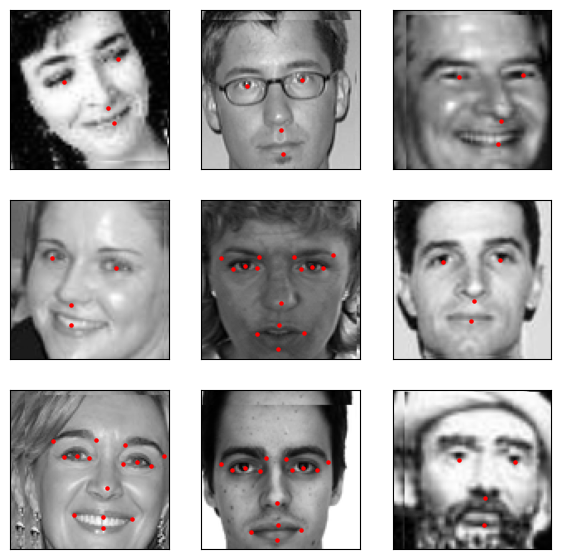

In [460]:
generator = ImageDataGenerator()
modifier = ShiftFlipPic()

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(x_train.reshape(-1,96,96,1)[:batch_size],y_train[:batch_size],seed=seed):
    X_batch, y_batch = modifier.fit(*batch)
    # Iterate through the batch and display each image
    for i in range(X_batch.shape[0]):
        ax = fig.add_subplot(3, 3, count, xticks=[], yticks=[])
        # Reshape the individual image to (height, width)
        ax.imshow(X_batch[i].reshape(96, 96), cmap="gray")
        ax.scatter(y_batch[i][0::2], y_batch[i][1::2],color='red', s=5)
        count += 1
        if count == 10:
            break
    if count == 10:
        break
plt.show()

In [461]:
class CustomDataGenerator(Sequence):
    def __init__(self, x, y, batch_size, image_data_generator, modifier, seed):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.image_data_generator = image_data_generator
        self.modifier = modifier
        self.seed = seed

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        batch_x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        augmented_x = self.image_data_generator.flow(batch_x, batch_y, batch_size=self.batch_size, shuffle=False, seed=seed)
        modified_x, modified_y = self.modifier.fit(*next(augmented_x))

        return modified_x, modified_y

    def on_epoch_end(self):
        # Optional: shuffle data or perform other end-of-epoch operations
        pass

Convolutions model

In [462]:
# Prepare for specialist training
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 4), (1, 5), (2, 6), (3, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 4), (1, 5), (2, 6), (3, 7)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),
    ]

In [463]:
if pretraining == True:
  pixel_num = x_train.shape[1]

  # Find rows with NaN values
  nan_rows = np.isnan(y_train).any(axis=1)

  # Use boolean indexing to drop rows with NaN values
  x_train = x_train[~nan_rows]
  y_train = y_train[~nan_rows]

  # Assuming you have defined the input shape of your images
  input_shape = (pixel_num, pixel_num, 1)

  # Create the CNN model
  net = keras.Sequential()

  # Convolutional Layer 1
  net.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  #net.add(BatchNormalization())
  net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.1))

  # Convolutional Layer 2
  net.add(Conv2D(64, (2, 2), activation='relu'))
  #net.add(BatchNormalization())
  net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.2))

  # Convolutional Layer 3
  net.add(Conv2D(128, (2, 2), activation='relu'))
  net.add(Dropout(0.2))

  # Convolutional Layer 4
  net.add(Conv2D(256, (2, 2), activation='relu'))
  net.add(BatchNormalization())
  net.add(Dropout(0.2))

  # Flatten the feature maps
  net.add(Flatten())

  # Fully Connected Layer 1
  #net.add(Dense(200, activation='relu'))
  #net.add(BatchNormalization())

  # Fully Connected Layer 2
  #net.add(Dense(200, activation='relu'))
  #net.add(BatchNormalization())

  # Output Layer
  net.add(Dense(y_train.shape[1]))

  ## Compile the model
  # net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

  # stop early
  early_stopping = EarlyStopping(monitor='val_loss',patience=80, restore_best_weights=True)

  # Create the Adam optimizer with the desired initial values
  optimizer = Adam(learning_rate=initial_lr, beta_1 = initial_momentum)

  # Compile the model and specify trainable variables
  net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy','mse'])

  history = net.fit(x_train,
                y_train,
                batch_size = batch_size,
                epochs = epochs,
                callbacks = [early_stopping, lr_callback, momentum_callback],
                validation_data=(x_test, y_test))

  # Data augmentation
  # Create an instance of ImageDataGenerator with desired augmentation settings
  # data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True)


In [464]:
if pretraining == False:
  # Convolutional neural net with three convolutional layers and two fully connected layers
  keras.backend.clear_session()
  pixel_num = np.sqrt(x_train.shape[1]).astype(int)
  # Assuming you have defined the input shape of your images
  input_shape = (pixel_num, pixel_num, 1)

  # Load pre-trained model
  base_model = load_model('/content/model.h5')
  # Create the CNN model
  net = keras.Sequential()

  # Convolutional Layer 1
  net.add(Conv2D(16, (2, 2), activation='relu', input_shape=input_shape))


  # Convolutional Layer 2
  net.add(Conv2D(16, (2, 2), activation='relu'))

  net.add(Conv2D(16, (2, 2), activation='relu'))
  net.add(Conv2D(16, (2, 2), activation='relu'))
  net.add(Conv2D(16, (2, 2), activation='relu'))
  net.add(Conv2D(32, (2, 2), activation='relu'))
  net.add(MaxPooling2D((2, 2)))
  net.summary()

  #net.add(MaxPooling2D((2, 2)))
  #

  #net.add(MaxPooling2D((2, 2)))
  #net.add(Dropout(0.1))
  #net.add(BatchNormalization())


  #net.load_weights('/content/model.h5',by_name=True)

  # Flatten the feature maps
  net.add(Flatten())

  # Fully Connected Layer 1
  #net.add(Dense(200, activation='relu'))
  #net.add(Dropout(0.2))

  ## Compile the model
  # net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

  # stop early
  early_stopping = EarlyStopping(monitor='val_loss',patience=50, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 95, 16)        80        
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 16)        1040      
                                                                 
 conv2d_2 (Conv2D)           (None, 93, 93, 16)        1040      
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 16)        1040      
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 16)        1040      
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        2080      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0

In [465]:
specialists = OrderedDict()
val_loss_values = []
training_loss_values = []
predictions_list = []
generator = ImageDataGenerator()


def fit_specialists(fname_pretrain=None):

  for setting in SPECIALIST_SETTINGS:
    cols = setting['columns']
    flip_indices = setting['flip_indices']
    modifier = ShiftFlipPic(flip_indices=flip_indices)
    x_train_cleaned, y_train_cleaned = load2d(cols=cols)
    x_test_cleaned, y_test_cleaned = load2d(test = True, cols = cols, fname = data_filename)

    # Find rows with NaN values
    nan_rows = np.isnan(y_train_cleaned).any(axis=1)

    # Use boolean indexing to drop rows with NaN values
    x_train_cleaned = x_train_cleaned[~nan_rows]
    y_train_cleaned = y_train_cleaned[~nan_rows]

    #Data augmentation
    train_generator = CustomDataGenerator(
        x_train_cleaned.reshape(-1, 96, 96, 1),
        y_train_cleaned,
        batch_size=batch_size,
        image_data_generator=generator,
        modifier=modifier,
        seed=seed)

    # Find rows with NaN values
    nan_rows = np.isnan(y_test_cleaned).any(axis=1)

    # Use boolean indexing to drop rows with NaN values
    x_test_cleaned = x_test_cleaned[~nan_rows]
    y_test_cleaned = y_test_cleaned[~nan_rows]

    model = clone_model(net)

    #Specialist layer
    model.add(Dense(128, activation='relu'))
    # Output Layer
    model.add(Dense(y_train_cleaned.shape[1], activation='linear'))

    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    # Create the Adam optimizer with the desired initial values
    optimizer = Adam(learning_rate=initial_lr, beta_1 = initial_momentum, clipvalue = 1)

    # Compile the model and specify trainable variables
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    print("Training model for columns {} for {} epochs".format(
        cols, epochs))

    history = model.fit(train_generator,
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [early_stopping, lr_callback, momentum_callback],
                        validation_data=(x_test_cleaned, y_test_cleaned))
    specialists[cols] = model

    # Calculate and store the loss value for this specialist
    val_loss = history.history['val_loss']
    training_loss = history.history['loss']
    val_loss_values.append((cols, val_loss))
    training_loss_values.append((cols, training_loss))

    # Make predictions using this specialist on the cleaned test data
    predictions = model.predict(x_test)
    predictions_list.append(predictions)

Analysis

In [466]:
if pretraining == False:
  fit_specialists()

  # Combine predictions from all specialists
  combined_predictions = np.hstack(predictions_list)
else:
  combined_predictions = net.predict(x_test)
  # Save the model to a file
  net.save('/content/model.h5')

# Calculate the loss value for the combined predictions
combined_loss = mean_squared_error(y_test, combined_predictions)

# Duration
duration = default_timer() - start
print(duration)
df['Duration'] = duration

Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 1000 epochs
Epoch 1/1000
  5/175 [..............................] - ETA: 4s - loss: 2099.4641 - accuracy: 0.8000

175/175 [==============================] - 7s 22ms/step - loss: 177.2057 - accuracy: 0.9914 - val_loss: 16.3385 - val_accuracy: 0.9950
Epoch 2/1000
175/175 [==============================] - 3s 20ms/step - loss: 18.6000 - accuracy: 0.9971 - val_loss: 12.8545 - val_accuracy: 0.9950
Epoch 3/1000
175/175 [==============================] - 4s 22ms/step - loss: 14.7426 - accuracy: 0.9971 - val_loss: 11.3630 - val_accuracy: 0.9950
Epoch 4/1000
175/175 [==============================] - 3s 19ms/step - loss: 13.5563 - accuracy: 0.9971 - val_loss: 10.2171 - val_accuracy: 0.9950
Epoch 5/1000
175/175 [==============================] - 3s 20ms/step - loss: 12.6373 - accuracy: 0.9971 - val_loss: 9.3577 - val_accuracy: 0.9950
Epoch 6/1000
175/175 [==============================] - 4s 22ms/step - loss: 11.8196 - accuracy: 0.9971 - val_loss: 8.6727 - val_accuracy: 0.9950
Epoch 7/1000
175/175 [==============================] - 3s 19ms/step - loss: 12.1350 - accuracy: 0.9971 - val_loss: 13.0887 - val_ac

56/56 [==============================] - 4s 25ms/step - loss: 415.5054 - accuracy: 0.8008 - val_loss: 30.6047 - val_accuracy: 1.0000
Epoch 2/1000
56/56 [==============================] - 1s 20ms/step - loss: 38.9959 - accuracy: 0.9989 - val_loss: 7.7701 - val_accuracy: 1.0000
Epoch 3/1000
56/56 [==============================] - 1s 20ms/step - loss: 18.6179 - accuracy: 0.9989 - val_loss: 9.5998 - val_accuracy: 1.0000
Epoch 4/1000
56/56 [==============================] - 1s 20ms/step - loss: 11.8907 - accuracy: 0.9989 - val_loss: 6.4843 - val_accuracy: 1.0000
Epoch 5/1000
56/56 [==============================] - 1s 20ms/step - loss: 10.6605 - accuracy: 0.9989 - val_loss: 6.4905 - val_accuracy: 1.0000
Epoch 6/1000
56/56 [==============================] - 1s 24ms/step - loss: 10.0748 - accuracy: 0.9989 - val_loss: 6.8537 - val_accuracy: 1.0000
Epoch 7/1000
56/56 [==============================] - 1s 22ms/step - loss: 8.8342 - accuracy: 0.9989 - val_loss: 9.4520 - val_accuracy: 1.0000
Epoc

55/55 [==============================] - 5s 25ms/step - loss: 393.3584 - accuracy: 0.9818 - val_loss: 61.3068 - val_accuracy: 1.0000
Epoch 2/1000
55/55 [==============================] - 1s 20ms/step - loss: 63.6671 - accuracy: 1.0000 - val_loss: 20.1619 - val_accuracy: 1.0000
Epoch 3/1000
55/55 [==============================] - 1s 20ms/step - loss: 37.6198 - accuracy: 1.0000 - val_loss: 15.5575 - val_accuracy: 1.0000
Epoch 4/1000
55/55 [==============================] - 1s 20ms/step - loss: 30.2410 - accuracy: 1.0000 - val_loss: 12.4331 - val_accuracy: 1.0000
Epoch 5/1000
55/55 [==============================] - 1s 20ms/step - loss: 21.5987 - accuracy: 1.0000 - val_loss: 10.5415 - val_accuracy: 1.0000
Epoch 6/1000
55/55 [==============================] - 1s 20ms/step - loss: 17.5980 - accuracy: 1.0000 - val_loss: 9.7789 - val_accuracy: 1.0000
Epoch 7/1000
55/55 [==============================] - 1s 19ms/step - loss: 15.6444 - accuracy: 1.0000 - val_loss: 12.4259 - val_accuracy: 1.000

176/176 [==============================] - 6s 21ms/step - loss: 235.1656 - accuracy: 0.9540 - val_loss: 28.6800 - val_accuracy: 0.9816
Epoch 2/1000
176/176 [==============================] - 3s 20ms/step - loss: 36.7431 - accuracy: 0.9540 - val_loss: 23.1960 - val_accuracy: 0.9816
Epoch 3/1000
176/176 [==============================] - 4s 20ms/step - loss: 28.0853 - accuracy: 0.9537 - val_loss: 21.6960 - val_accuracy: 0.9816
Epoch 4/1000
176/176 [==============================] - 4s 21ms/step - loss: 27.4292 - accuracy: 0.9540 - val_loss: 19.5246 - val_accuracy: 0.9816
Epoch 5/1000
176/176 [==============================] - 4s 20ms/step - loss: 25.6628 - accuracy: 0.9545 - val_loss: 19.6865 - val_accuracy: 0.9816
Epoch 6/1000
176/176 [==============================] - 3s 19ms/step - loss: 22.7481 - accuracy: 0.9561 - val_loss: 21.6886 - val_accuracy: 0.9816
Epoch 7/1000
176/176 [==============================] - 4s 21ms/step - loss: 21.8078 - accuracy: 0.9563 - val_loss: 18.2212 - val_

57/57 [==============================] - 5s 25ms/step - loss: 1074.1589 - accuracy: 0.2736 - val_loss: 97.5877 - val_accuracy: 0.4273
Epoch 2/1000
57/57 [==============================] - 1s 19ms/step - loss: 58.0124 - accuracy: 0.4008 - val_loss: 24.9578 - val_accuracy: 0.4296
Epoch 3/1000
57/57 [==============================] - 1s 20ms/step - loss: 44.0443 - accuracy: 0.4567 - val_loss: 20.7427 - val_accuracy: 0.4342
Epoch 4/1000
57/57 [==============================] - 1s 20ms/step - loss: 37.8789 - accuracy: 0.4605 - val_loss: 19.5081 - val_accuracy: 0.4665
Epoch 5/1000
57/57 [==============================] - 1s 19ms/step - loss: 28.2884 - accuracy: 0.5049 - val_loss: 28.7960 - val_accuracy: 0.6490
Epoch 6/1000
57/57 [==============================] - 1s 20ms/step - loss: 22.6450 - accuracy: 0.5263 - val_loss: 19.4574 - val_accuracy: 0.5912
Epoch 7/1000
57/57 [==============================] - 1s 20ms/step - loss: 19.1618 - accuracy: 0.6184 - val_loss: 18.6346 - val_accuracy: 0.6

175/175 [==============================] - 7s 24ms/step - loss: 251.4681 - accuracy: 0.9977 - val_loss: 34.9594 - val_accuracy: 0.9986
Epoch 2/1000
175/175 [==============================] - 3s 19ms/step - loss: 37.6336 - accuracy: 0.9979 - val_loss: 28.9918 - val_accuracy: 0.9986
Epoch 3/1000
175/175 [==============================] - 4s 20ms/step - loss: 28.9398 - accuracy: 0.9979 - val_loss: 20.2438 - val_accuracy: 0.9986
Epoch 4/1000
175/175 [==============================] - 4s 22ms/step - loss: 26.0788 - accuracy: 0.9979 - val_loss: 16.4792 - val_accuracy: 0.9986
Epoch 5/1000
175/175 [==============================] - 4s 20ms/step - loss: 24.1905 - accuracy: 0.9979 - val_loss: 15.1745 - val_accuracy: 0.9986
Epoch 6/1000
175/175 [==============================] - 3s 19ms/step - loss: 21.4937 - accuracy: 0.9979 - val_loss: 15.4241 - val_accuracy: 0.9986
Epoch 7/1000
175/175 [==============================] - 4s 22ms/step - loss: 24.2083 - accuracy: 0.9979 - val_loss: 24.8567 - val_

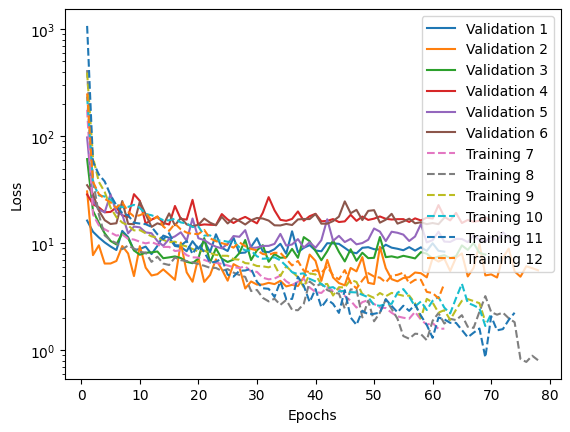

In [467]:
plt.figure()
i = 1
for index, value in enumerate(val_loss_values):
    plt.plot(range(1, len(value[1])+1), value[1], label='Validation ' + str(i))
    i+=1
for index, value in enumerate(training_loss_values):
    plt.plot(range(1, len(value[1])+1), value[1], label='Training ' + str(i),linestyle='--')
    i+=1
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [468]:
# First, calculate the column means along axis 0 (columns)
col_means = np.nanmean(y_test, axis=0)

# Next, create the matrix 'p' using the calculated column means
num_rows_d_test = y_test.shape[0]
num_cols_d_train = y_train.shape[1]

# Print RMSE
print('RMSE : ')
print(combined_loss)
df['RMSE'] = combined_loss
df.to_csv('/content/performance.csv',mode='a')

RMSE : 
5.6147904


In [469]:
df_predictions = pd.DataFrame(combined_predictions)

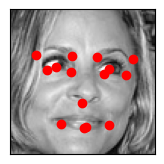

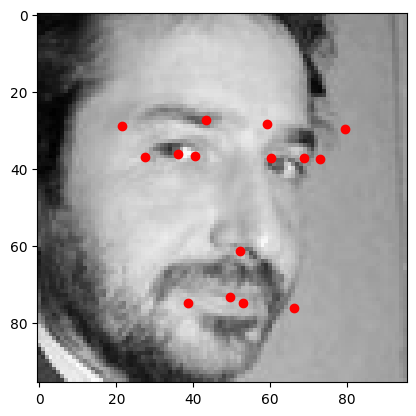

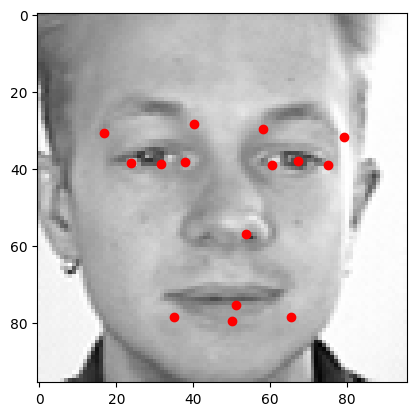

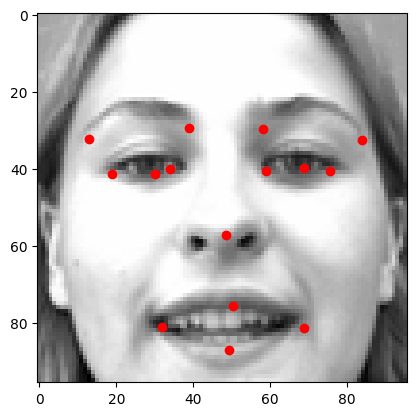

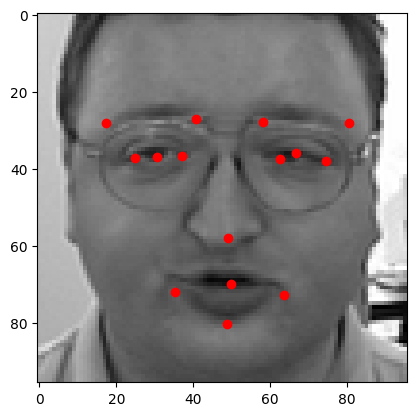

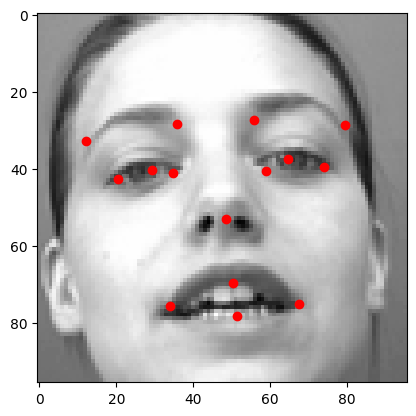

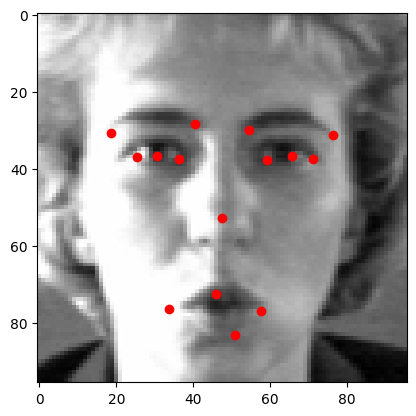

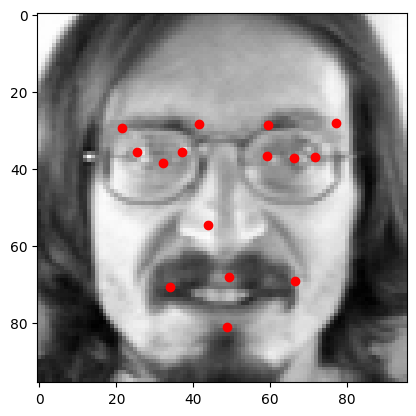

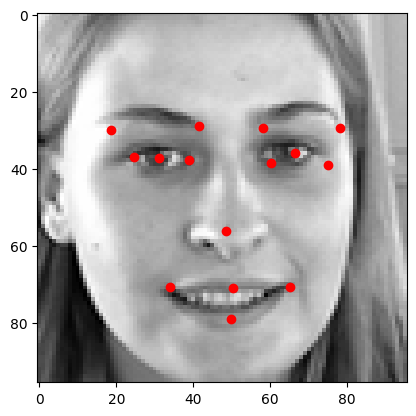

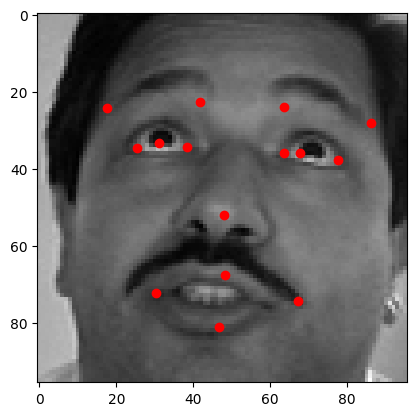

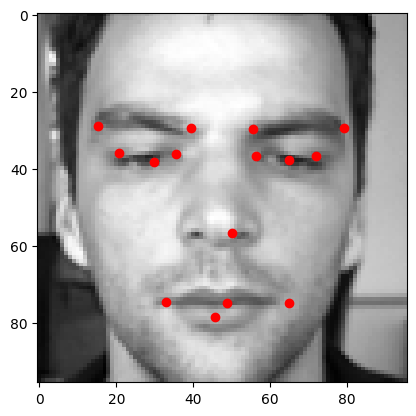

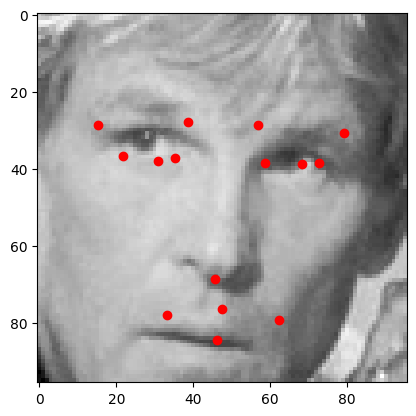

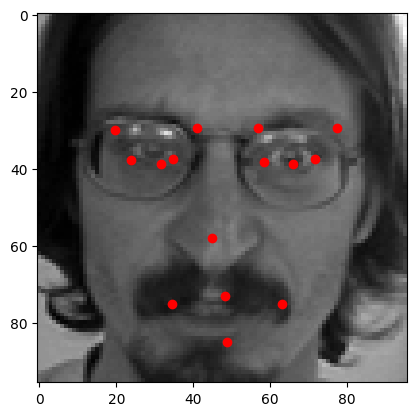

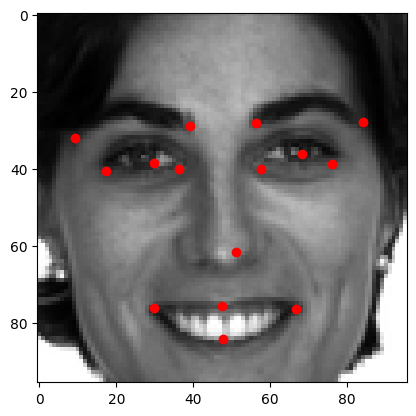

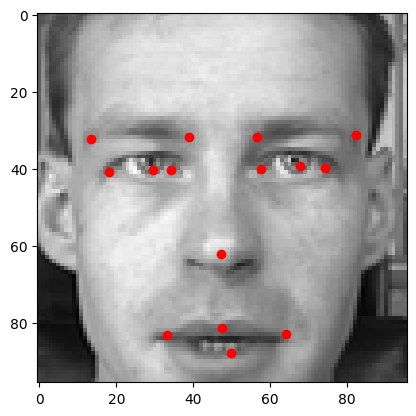

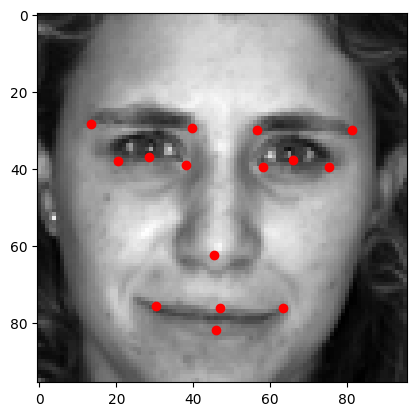

In [470]:
# Plot the first 16 images in the DataFrame

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
  if model_type == 'Single hidden layer':
    image = np.array(x_test.iloc[i,:])  # Convert the Series to a NumPy array
    image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
  elif model_type == 'Convolutions':
    image = x_test[i]
    image = image.reshape((96, 96))
  ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
  predicted_keypoints = combined_predictions[i].reshape((15, 2))
  plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
  plt.imshow(image, cmap='gray')
  plt.show()

56/56 [==============================] - 0s 3ms/step


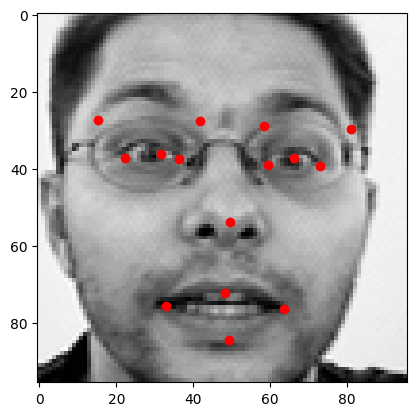

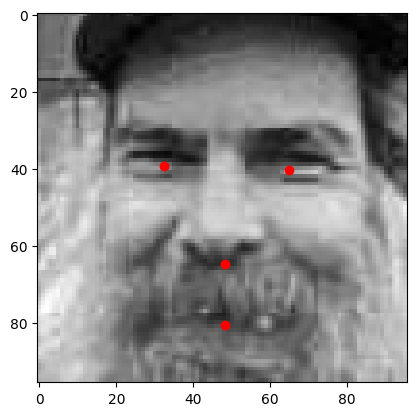

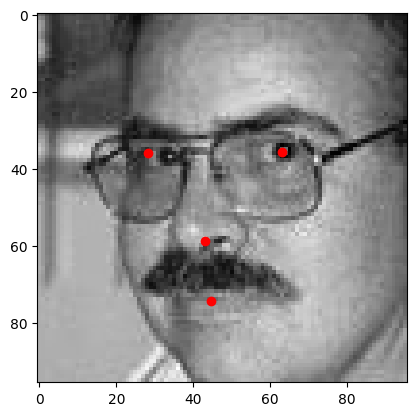

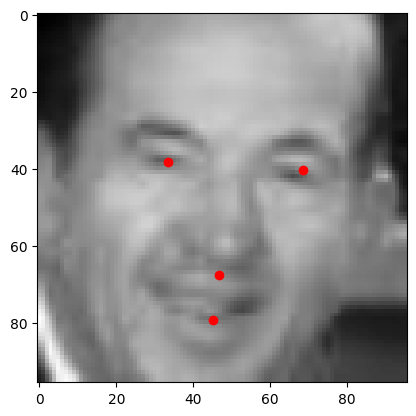

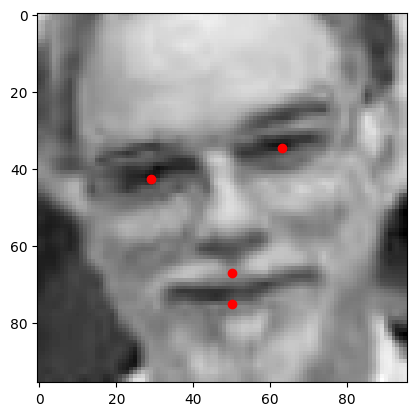

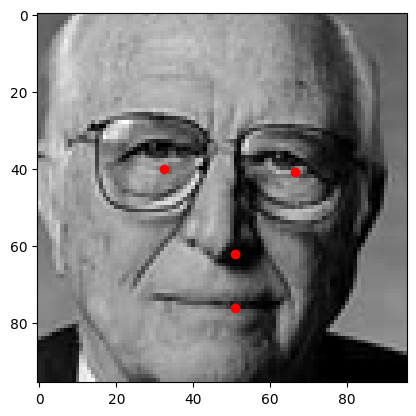

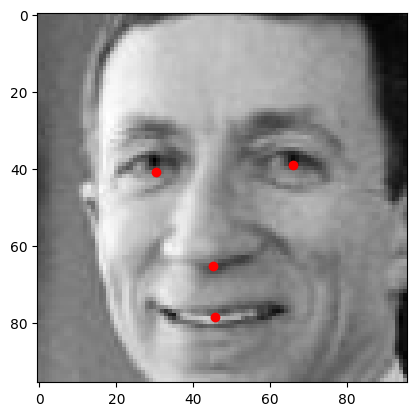

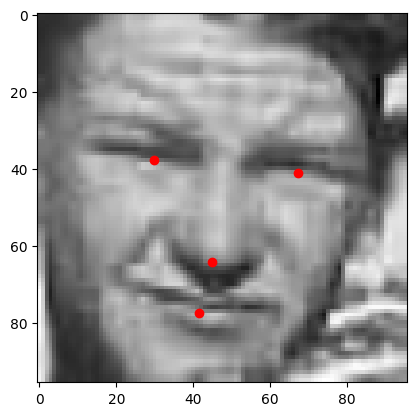

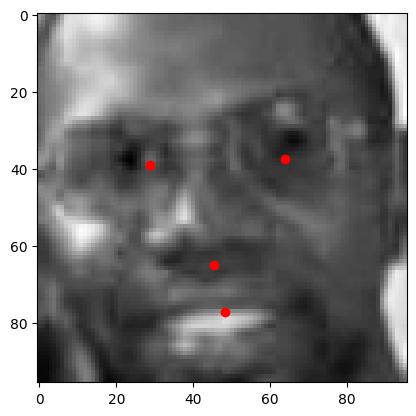

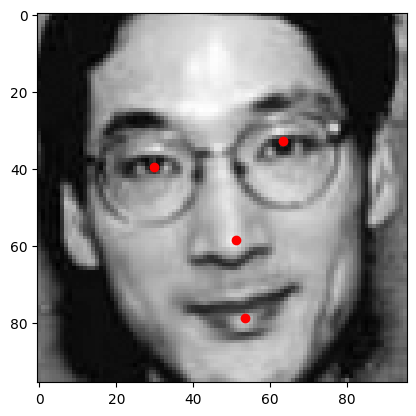

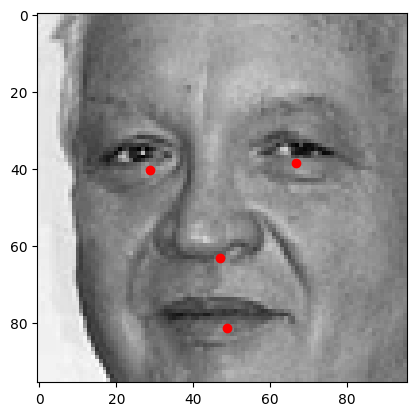

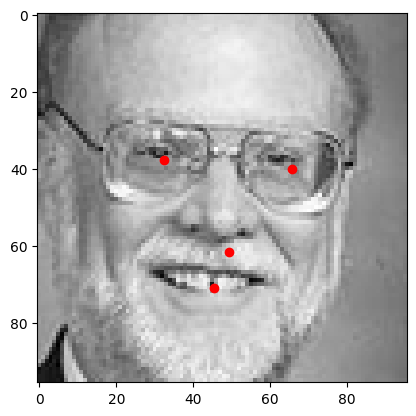

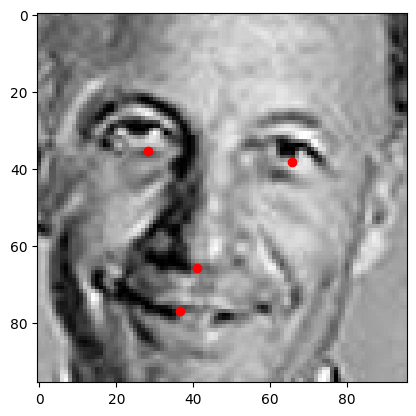

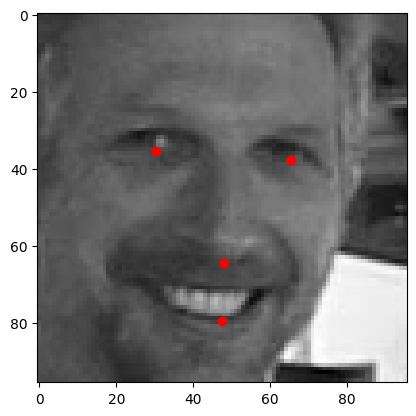

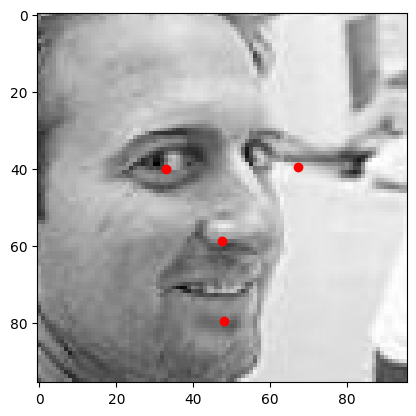

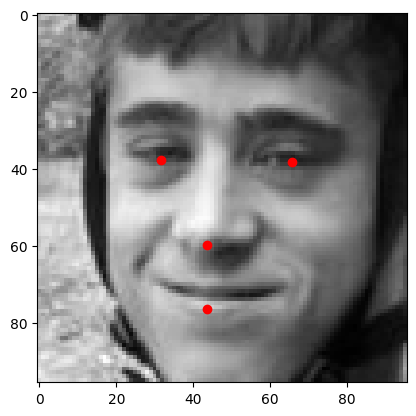

In [471]:
#TODO move below
# from pandas.io.parsers.readers import read_csv
# Extract data for output
x_submission = load2d(fname = submission_filename)
if pretraining == False:
  submission_predictions_list = []

  for setting in SPECIALIST_SETTINGS:
      cols = setting['columns']
      x_submission, _ = load2d(cols=cols,fname = submission_filename)

      # Make predictions using this specialist on the cleaned test data
      submission_predictions = specialists[cols].predict(x_submission)
      submission_predictions_list.append(submission_predictions)

  # Make predictions
  predictions_submission = np.hstack(submission_predictions_list)
else:
  x_submission, _ = load2d(fname = submission_filename)
  predictions_submission = net.predict(x_submission)

predictions_submission[predictions_submission < 0] = 0
predictions_submission[predictions_submission > 96] = 96
# Remove predictions not requested in IdLookupTable.csv
filename = '/content/IdLookupTable.csv'
IdLookupTable = pd.read_csv(filename)
# All keypoints names
keypoints_names = IdLookupTable['FeatureName'].iloc[0:30]
# Calculate the repeating sequence based on the number of rows in 'df'
repeating_sequence = np.repeat(np.arange(1, 1783*30 // 30 + 1), 30)
# Add the repeating sequence as a new column to the DataFrame
keypoints_names_filter = pd.DataFrame({'ImageId': repeating_sequence})
keypoints_names_filter['Indices'] = range(len(keypoints_names_filter))
keypoints_names_filter['FeatureName'] = pd.concat([keypoints_names] * 1783, ignore_index=True)
# Filter
keypoints_names_filter = keypoints_names_filter.merge(IdLookupTable[['ImageId', 'FeatureName']], on=['ImageId', 'FeatureName'], how='inner')
# Create a mask of size 1783x30 where True indicates the indices to keep
nb_output_images = x_submission.shape[0]
mask = np.isin(np.arange(nb_output_images*30), keypoints_names_filter['Indices'])
# Reshape the mask to the same shape as 'np_array'
mask = mask.reshape(predictions_submission.shape)
# Use the mask to replace values in the NumPy array with NaN
predictions_submission[~mask] = np.nan

# Plot the first image in the DataFrame
for i in range(16):
  if model_type == 'Single hidden layer':
    image = np.array(x_submission.iloc[-i,:])
    image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
  elif model_type == 'Convolutions':
    image = x_submission[-i]
    image = image.reshape((96, 96))
  predicted_keypoints = predictions_submission[-i].reshape((15, 2))
  plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
  plt.imshow(image, cmap='gray')
  plt.show()

# Prepare for output file
df_predictions = pd.DataFrame(predictions_submission)

# Convert the DataFrame to a NumPy array and reshape it
reshaped_values = df_predictions.values.reshape(-1, 1)

# Remove NaN values from the NumPy array
reshaped_values = reshaped_values[~np.isnan(reshaped_values)]

# Create a new DataFrame with the reshaped values
reshaped_df = pd.DataFrame(reshaped_values, columns=['Value'])
indices = pd.DataFrame(range(1,len(reshaped_df)+1))
submission = pd.concat([indices, reshaped_df], axis=1)
submission.rename(columns={0: 'RowId','Value': 'Location'}, inplace=True)

# Write to csv file
submission.to_csv('/content/model_submission.csv',index=False)
